In [0]:
## Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_extract, sum, count
import matplotlib.pyplot as plt


In [0]:
##Create Spark Session
spark = SparkSession.builder \
    .appName("Titanic-FeatureEngineering-Full") \
    .getOrCreate()


In [0]:
df = spark.read.csv("/Volumes/workspace/default/titanic/tested.csv", header=True, inferSchema=True)

# Quick view
df.show(5)
df.printSchema()

+-----------+--------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch| Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|        892|       0|     3|    Kelly, Mr. James|  male|34.5|    0|    0| 330911| 7.8292| NULL|       Q|
|        893|       1|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0| 363272|    7.0| NULL|       S|
|        894|       0|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0| 240276| 9.6875| NULL|       Q|
|        895|       0|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0| 315154| 8.6625| NULL|       S|
|        896|       1|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|3101298|12.2875| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
only showing top 5 rows
root
 |-- PassengerId:

In [0]:
# Check unique values for categorical columns
df.select('Sex').distinct().show()
df.select('Embarked').distinct().show()
df.select('Pclass').distinct().show()

# Summary stats for numeric columns
df.describe(["Age", "Fare", "SibSp", "Parch"]).show()

# Check overall survival
df.groupBy("Survived").count().show()


+------+
|   Sex|
+------+
|  male|
|female|
+------+

+--------+
|Embarked|
+--------+
|       Q|
|       S|
|       C|
+--------+

+------+
|Pclass|
+------+
|     1|
|     3|
|     2|
+------+

+-------+------------------+-----------------+------------------+------------------+
|summary|               Age|             Fare|             SibSp|             Parch|
+-------+------------------+-----------------+------------------+------------------+
|  count|               332|              417|               418|               418|
|   mean|30.272590361445783| 35.6271884892086|0.4473684210526316|0.3923444976076555|
| stddev| 14.18120923562442|55.90757617997383|0.8967595611217125|0.9814288785371684|
|    min|              0.17|              0.0|                 0|                 0|
|    max|              76.0|         512.3292|                 8|                 9|
+-------+------------------+-----------------+------------------+------------------+

+--------+-----+
|Survived|count|
+--

In [0]:
##Handling Missing Values
# Fill missing Embarked
df = df.fillna({"Embarked": "S"})

# Drop Cabin column
df = df.drop("Cabin")

# Check missing values per column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-----------+--------+------+----+---+---+-----+-----+------+----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+
|          0|       0|     0|   0|  0| 86|    0|    0|     0|   1|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+



In [0]:
## Feature Engineering
# FamilySize
df = df.withColumn("FamilySize", col("SibSp") + col("Parch") + 1)

# isAlone
df = df.withColumn("isAlone", when(col("FamilySize") == 1, 1).otherwise(0))

# Extract Title from Name
df = df.withColumn("Title", regexp_extract(col("Name"), r', (\w+)\.', 1))

# Drop unnecessary columns
df = df.drop("Name", "PassengerId", "Ticket")

# Map categorical columns to indexes
df = df.withColumn("Sex_Index", when(col("Sex")=="male", 0).otherwise(1))
df = df.withColumn("Embarked_Index", 
                   when(col("Embarked")=="S", 0)
                   .when(col("Embarked")=="C", 1)
                   .otherwise(2))
df = df.withColumn("Title_Index",
                   when(col("Title")=="Mr", 0)
                   .when(col("Title")=="Mrs", 1)
                   .when(col("Title")=="Miss", 2)
                   .when(col("Title")=="Master", 3)
                   .otherwise(4))


In [0]:
## Survival Rate by Exploration

# Survival rate by Sex
df.groupBy("Sex").agg((sum("Survived")/count("Survived")).alias("SurvivalRate")).show()

# Survival rate by Pclass
df.groupBy("Pclass").agg((sum("Survived")/count("Survived")).alias("SurvivalRate")).show()

# Survival rate by Age Groups
df_age_bucket = df.withColumn("AgeGroup",
                              when(col("Age") <= 12, "Child")
                              .when((col("Age") > 12) & (col("Age") < 18), "Teen")
                              .when((col("Age") >= 18) & (col("Age") < 60), "Adult")
                              .otherwise("Senior"))

df_age_bucket.groupBy("AgeGroup", "Survived").count().show()

# Survival rate by FamilySize
df.groupBy("FamilySize") \
  .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByFamilySize")) \
  .orderBy("FamilySize").show()

# Survival rate by isAlone
df.groupBy("isAlone") \
  .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByIsAlone")).show()

# Survival rate by Title
df.groupBy("Title") \
  .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByTitle")).show()

# Survival rate by Embarked
df.groupBy("Embarked") \
  .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByEmbarked")).show()


+------+------------+
|   Sex|SurvivalRate|
+------+------------+
|  male|         0.0|
|female|         1.0|
+------+------------+

+------+------------------+
|Pclass|      SurvivalRate|
+------+------------------+
|     1|0.4672897196261682|
|     3|0.3302752293577982|
|     2|0.3225806451612903|
+------+------------------+

+--------+--------+-----+
|AgeGroup|Survived|count|
+--------+--------+-----+
|  Senior|       1|   32|
|   Adult|       0|  174|
|   Child|       0|   13|
|    Teen|       1|    5|
|  Senior|       0|   68|
|   Child|       1|   12|
|   Adult|       1|  103|
|    Teen|       0|   11|
+--------+--------+-----+

+----------+------------------------+
|FamilySize|SurvivalRateByFamilySize|
+----------+------------------------+
|         1|     0.26877470355731226|
|         2|      0.4864864864864865|
|         3|      0.5263157894736842|
|         4|      0.7142857142857143|
|         5|      0.2857142857142857|
|         6|      0.6666666666666666|
|         7|   

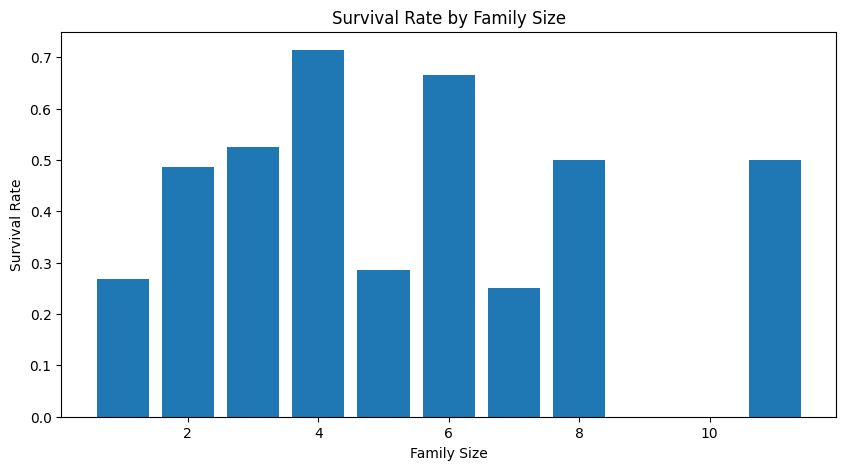

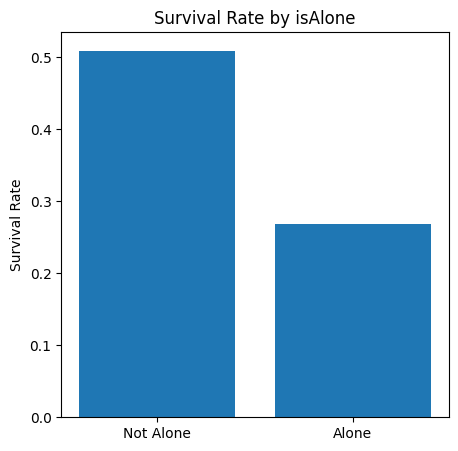

In [0]:
## Visualization 
# FamilySize vs Survival Rate
family_survival = df.groupBy("FamilySize") \
                    .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByFamilySize"))
family_survival_pd = family_survival.toPandas()

plt.figure(figsize=(10,5))
plt.bar(family_survival_pd["FamilySize"], family_survival_pd["SurvivalRateByFamilySize"])
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Family Size")
plt.show()

# isAlone vs Survival Rate
isAlone_survival = df.groupBy("isAlone") \
                     .agg((sum("Survived")/count("Survived")).alias("SurvivalRateByIsAlone"))
isAlone_pd = isAlone_survival.toPandas()

plt.figure(figsize=(5,5))
plt.bar(isAlone_pd["isAlone"], isAlone_pd["SurvivalRateByIsAlone"])
plt.xticks([0,1], ["Not Alone", "Alone"])
plt.ylabel("Survival Rate")
plt.title("Survival Rate by isAlone")
plt.show()


In [0]:
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- FamilySize: integer (nullable = true)
 |-- isAlone: integer (nullable = false)
 |-- Title: string (nullable = true)
 |-- Sex_Index: integer (nullable = false)
 |-- Embarked_Index: integer (nullable = false)
 |-- Title_Index: integer (nullable = false)



In [0]:

## Select only numeric/indexed columns
from pyspark.sql.functions import col

# 1️⃣ Select only numeric/indexed columns
numeric_indexed_cols = [
    "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare", "FamilySize", "isAlone", 
    "Sex_Index", "Embarked_Index", "Title_Index"
]

df_numeric = df.select([col(c) for c in numeric_indexed_cols])

df_numeric.show()

+--------+------+----+-----+-----+-------+----------+-------+---------+--------------+-----------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|FamilySize|isAlone|Sex_Index|Embarked_Index|Title_Index|
+--------+------+----+-----+-----+-------+----------+-------+---------+--------------+-----------+
|       0|     3|34.5|    0|    0| 7.8292|         1|      1|        0|             2|          0|
|       1|     3|47.0|    1|    0|    7.0|         2|      0|        1|             0|          1|
|       0|     2|62.0|    0|    0| 9.6875|         1|      1|        0|             2|          0|
|       0|     3|27.0|    0|    0| 8.6625|         1|      1|        0|             0|          0|
|       1|     3|22.0|    1|    1|12.2875|         3|      0|        1|             0|          1|
|       0|     3|14.0|    0|    0|  9.225|         1|      1|        0|             0|          0|
|       1|     3|30.0|    0|    0| 7.6292|         1|      1|        1|             2|          2|
|       0|

In [0]:
parquet_path = "/tmp/titanic_numeric"
csv_path = "/tmp/titanic_numeric_csv"

# Save as Parquet
df_numeric.write.mode("overwrite").parquet(parquet_path)

# Save as CSV
df_numeric.write.mode("overwrite").option("header", True).csv(csv_path)

# Verify Parquet
print("Sample from Parquet:")
spark.read.parquet(parquet_path).show(5)

# Verify CSV
print("Sample from CSV:")
spark.read.option("header", True).csv(csv_path).show(5)

---------------------------------------------------------------------------
UnsupportedOperationException             Traceback (most recent call last)
File <command-7150696443306657>, line 5
      2 csv_path = "/tmp/titanic_numeric_csv"
      4 # Save as Parquet
----> 5 df_numeric.write.mode("overwrite").parquet(parquet_path)
      7 # Save as CSV
      8 df_numeric.write.mode("overwrite").option("header", True).csv(csv_path)

File /databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/readwriter.py:755, in DataFrameWriter.parquet(self, path, mode, partitionBy, compression)
    753     self.partitionBy(partitionBy)
    754 self._set_opts(compression=compression)
--> 755 self.format("parquet").save(path)

File /databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/readwriter.py:679, in DataFrameWriter.save(self, path, format, mode, partitionBy, **options)
    677     self.format(format)
    678 self._write.path = path
--> 679 _, _, ei = self._spark.client.exec